## 1) Problem Statement

Classify the drugs based on their features.

## 2) Data Collection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.stats as ss
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from collections import Counter
from mixed_naive_bayes import MixedNB
from sklearn.preprocessing import FunctionTransformer,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import pickle

In [2]:
data = pd.read_csv(r"drug200.csv")

In [3]:
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## 3) Simple EDA for Understading Data

In [4]:
data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [5]:
data.shape # To check how many rows and columns are present inside Dataset

(200, 6)

In [6]:
data.info() # To check the infomation about Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [7]:
data.isnull().sum() # To check if null values is present or not

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

**There is no Null values in our Dataset**

In [8]:
categorical_columns = ['Sex', 'BP', 'Cholesterol']

for col in categorical_columns:
    print(data[col].value_counts())

Sex
M    104
F     96
Name: count, dtype: int64
BP
HIGH      77
LOW       64
NORMAL    59
Name: count, dtype: int64
Cholesterol
HIGH      103
NORMAL     97
Name: count, dtype: int64


In [9]:
data.duplicated().sum() # To check if duplicate data is present or not

0

**There is no Duplicate values in our dataset**

In [10]:
data['Drug'].value_counts() # To check if dataset is balanced or imbalanced

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

In [11]:
datac = data.copy()

In [12]:
datac.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [13]:
lb = LabelEncoder()  # To convert categorical variables into numerical format
datac["Drug"] = lb.fit_transform(datac["Drug"])

In [14]:
# Creating a mapping between original drug names and encoded numbers
drug_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))

# Printing the mapping
print("Drug Mapping:")
for drug, code in drug_mapping.items():
    print(f"{drug}: {code}")

Drug Mapping:
DrugY: 0
drugA: 1
drugB: 2
drugC: 3
drugX: 4


In [15]:
feature_var = datac.iloc[:,0:-1]
class_label = datac.iloc[:,-1] 

In [16]:
feature_var.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [17]:
class_label.head()

0    0
1    3
2    3
3    4
4    0
Name: Drug, dtype: int32

## 4) Data Pre-Processing

### Dividing Feature_var into 3 parts, i.e., numerical_data, nominal_data and ordinal_data

In [18]:
numerical_data = feature_var[["Age", "Na_to_K"]]
nominal_data = feature_var[["Sex"]]
ordinal_data = feature_var[["BP", "Cholesterol"]]

### Creating Pipeline

In [19]:
num_p = Pipeline(steps=[("Imputation", SimpleImputer()),("Scaling", StandardScaler()),("Power Transformer", PowerTransformer("yeo-johnson"))])
nom_p = Pipeline(steps=[("Imputation", SimpleImputer(strategy="most_frequent")), ("OH_Encoding", OneHotEncoder())])
ord_p = Pipeline(steps=[("Imputation", SimpleImputer(strategy="most_frequent")), ("O_Encoding", OrdinalEncoder())])

In [20]:
feature_var["BP"]

0        HIGH
1         LOW
2         LOW
3      NORMAL
4         LOW
        ...  
195       LOW
196       LOW
197    NORMAL
198    NORMAL
199       LOW
Name: BP, Length: 200, dtype: object

In [21]:
ct_p = ColumnTransformer([("Numerical", num_p, numerical_data.columns),
                          ("Nominal_Categorical", nom_p, nominal_data.columns),
                          ("Ordinal_Categorical", ord_p, ordinal_data.columns)], remainder="passthrough")

### Dividing feature_var into train and test then divide train into train and cv

In [22]:
x_train, x_test, y_train, y_test = train_test_split(feature_var, class_label, test_size=0.2, random_state=2, stratify=class_label)

In [23]:
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=2, stratify=y_train)

## 5) EDA

In [24]:
data_eda = pd.concat([x_train, y_train], axis = 1)
data_eda 

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
150,49,M,HIGH,NORMAL,8.700,1
89,50,F,NORMAL,NORMAL,17.211,0
80,60,M,HIGH,HIGH,13.934,2
69,18,F,HIGH,NORMAL,24.276,0
191,23,M,HIGH,HIGH,8.011,1
...,...,...,...,...,...,...
29,45,M,LOW,HIGH,17.951,0
42,50,M,NORMAL,NORMAL,15.790,0
79,32,F,LOW,NORMAL,10.840,4
186,70,M,HIGH,HIGH,9.849,2


### Below code is used to remove warning 

In [25]:
import warnings
warnings.filterwarnings('ignore')

### Histogram for Numerical Data

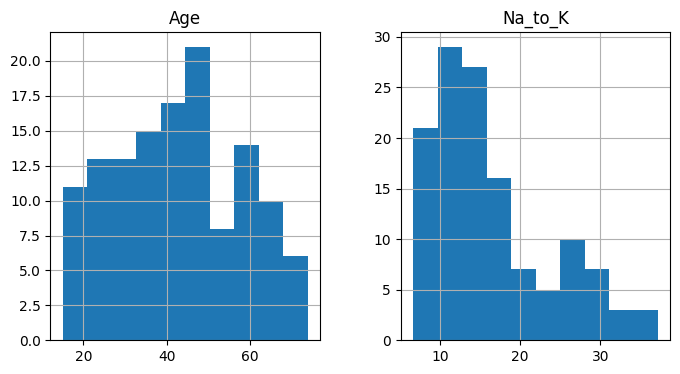

In [26]:
data_eda.hist(column=['Age', 'Na_to_K'], figsize=(8,4))
plt.show()

**--> In Age column, more peoples are around 45-50 & In Na_to_K column, average is around 10-13.**

### Count Plot for Categorical Data

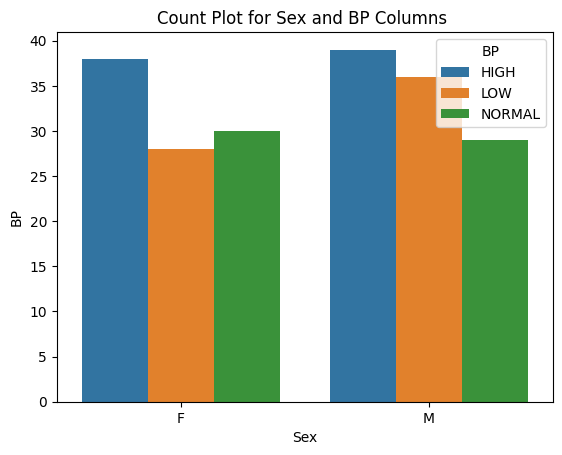

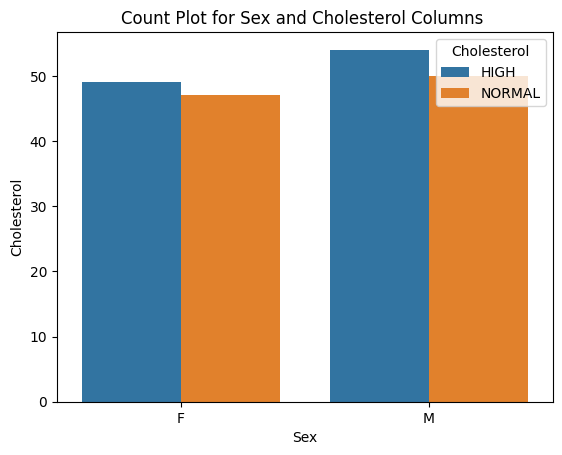

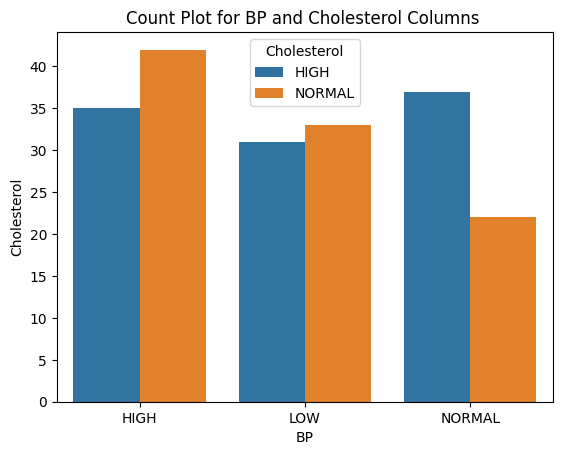

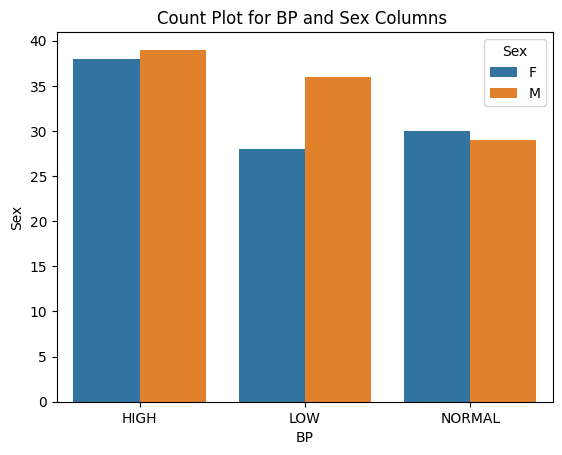

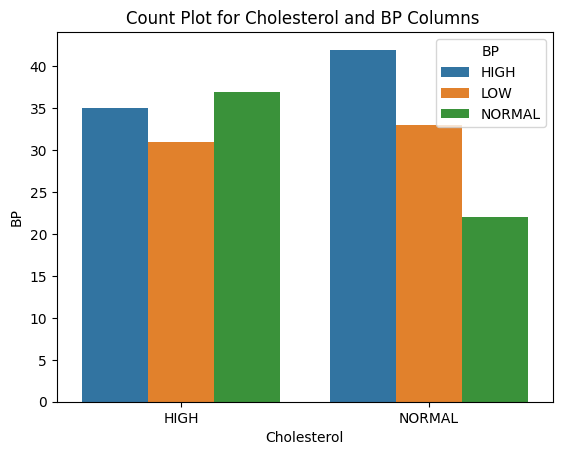

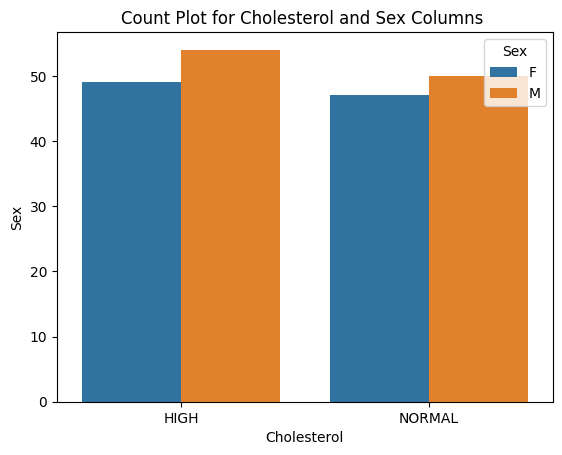

In [27]:
c_col = ['Sex', 'BP', 'Cholesterol']
hue = ['BP', 'Cholesterol', 'Sex']

for i in c_col:
    for j in hue:
        if i == j:
            pass
        else:            
            sns.countplot(data=feature_var, x=i, hue=j)
            plt.title(f'Count Plot for {i} and {j} Columns ')
            plt.xlabel(i)
            plt.ylabel(j)
            plt.show()

### Correlation for Numerical Data

<Axes: >

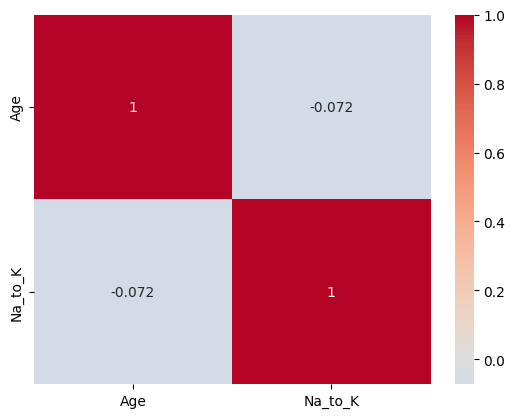

In [28]:
numerical_columns = ['Age', 'Na_to_K']
numerical_data = x_train[numerical_columns]
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm', center=0)

## 6) Training

In [29]:
x_train_t = ct_p.fit_transform(x_train)
x_train_t

array([[ 0.42753935, -1.36971046,  0.        ,  1.        ,  0.        ,
         1.        ],
       [ 0.49047055,  0.44919332,  1.        ,  0.        ,  2.        ,
         1.        ],
       [ 1.10855857, -0.09789398,  0.        ,  1.        ,  0.        ,
         0.        ],
       [-1.6534239 ,  1.17917826,  1.        ,  0.        ,  0.        ,
         1.        ],
       [-1.30409309, -1.57252841,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.67791819, -0.39952983,  1.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.30093572, -0.90336786,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 1.41135434, -0.13059883,  1.        ,  0.        ,  1.        ,
         1.        ],
       [-0.02059904,  0.7879919 ,  0.        ,  1.        ,  1.        ,
         0.        ],
       [ 1.59139727, -0.95921744,  1.        ,  0.        ,  0.        ,
         1.        ],
       [-1.30409309,  0.3982972 ,  0.        ,  1.

In [30]:
x_cv_t = ct_p.transform(x_cv)
x_test_t = ct_p.transform(x_test)

In [31]:
ct_p.get_feature_names_out()

array(['Numerical__Age', 'Numerical__Na_to_K',
       'Nominal_Categorical__Sex_F', 'Nominal_Categorical__Sex_M',
       'Ordinal_Categorical__BP', 'Ordinal_Categorical__Cholesterol'],
      dtype=object)

In [32]:
pd.DataFrame(x_train_t)

,0,1,2,3,4,5
0,0.427539,-1.369710,0.0,1.0,0.0,1.0
1,0.490471,0.449193,1.0,0.0,2.0,1.0
2,1.108559,-0.097894,0.0,1.0,0.0,0.0
3,-1.653424,1.179178,1.0,0.0,0.0,1.0
4,-1.304093,-1.572528,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
123,0.173252,0.547600,0.0,1.0,1.0,0.0
124,0.490471,0.235952,0.0,1.0,2.0,1.0
125,-0.686103,-0.791792,1.0,0.0,1.0,1.0
126,1.710807,-1.049582,0.0,1.0,0.0,0.0


In [33]:
mb=MixedNB(categorical_features=[2,3,4,5],alpha=1)
model=mb.fit(x_train_t,y_train)

In [34]:
predicted_yi=model.predict(x_cv_t)

Confusion Matrix:



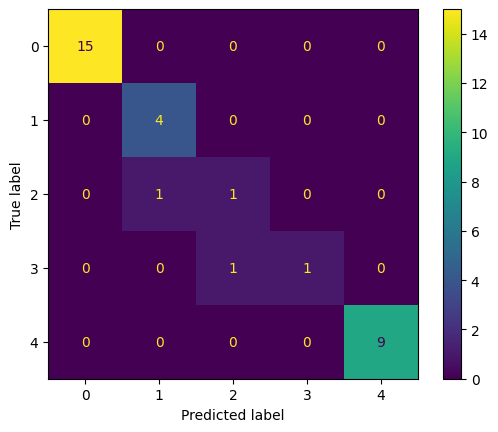


Accuracy Score:  93.75


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.80      1.00      0.89         4
           2       0.50      0.50      0.50         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         9

    accuracy                           0.94        32
   macro avg       0.86      0.80      0.81        32
weighted avg       0.94      0.94      0.93        32



In [35]:
print("Confusion Matrix:\n")
cm = confusion_matrix(y_cv, predicted_yi)
i = ConfusionMatrixDisplay(cm)
i.plot()
plt.show()

print("\nAccuracy Score: ",accuracy_score(y_cv, predicted_yi)*100)


print("\n\nClassification Report:\n",classification_report(y_cv, predicted_yi))

## 7) Testing 

In [36]:
mb=MixedNB(categorical_features=[2,3,4,5],alpha=1)
model=mb.fit(x_train_t,y_train)
predicted_yi=model.predict(x_test_t)

Confusion Matrix:



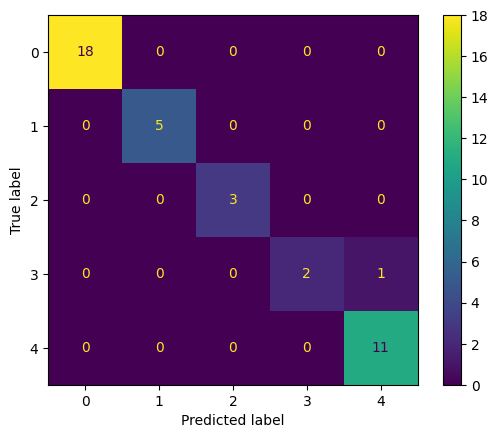


Accuracy Score:  97.5


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         3
           3       1.00      0.67      0.80         3
           4       0.92      1.00      0.96        11

    accuracy                           0.97        40
   macro avg       0.98      0.93      0.95        40
weighted avg       0.98      0.97      0.97        40



In [37]:
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, predicted_yi)
i = ConfusionMatrixDisplay(cm)
i.plot()
plt.show()

print("\nAccuracy Score: ",accuracy_score(y_test, predicted_yi)*100)


print("\n\nClassification Report:\n",classification_report(y_test, predicted_yi))

## 8) Deployment

In [38]:
#This will serialize the object and convert it into a “byte stream”
pickle.dump(ct_p,open(r"C:\Users\Ajay\Studies\Machine Learning\Assignment\drugs_pre.pkl", "wb")) 

In [39]:
#This will de-serialize the object
pre = pickle.load(open(r"C:\Users\Ajay\Studies\Machine Learning\Assignment\drugs_pre.pkl", "rb"))

In [40]:
#This will serialize the object and convert it into a “byte stream”
pickle.dump(model,open(r"C:\Users\Ajay\Studies\Machine Learning\Assignment\drugs_model.pkl", "wb")) 

In [41]:
#This will de-serialize the object
model = pickle.load(open(r"C:\Users\Ajay\Studies\Machine Learning\Assignment\drugs_model.pkl", "rb"))

### Query Point

In [44]:
query = pd.DataFrame([[39, "M", "HIGH", "HIGH", 9.664]],
                 columns=['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'])

# Transform input data
query_trans = pre.transform(query)

# Predict and display result
predicted_yi = model.predict(query_trans)
print(predicted_yi)

[1]


In [47]:
if predicted_yi == 0:
    result = "**DrugY**"
elif predicted_yi == 1:
    result = "**drugA**"
elif predicted_yi == 2:
    result = "**drugB**"
elif predicted_yi == 3:
    result = "**drugC**"
elif predicted_yi == 4:
    result = "**drugX**"
else:
    result = "**Error**"
    
print(result)

**drugA**
